In [271]:
import pandas as pd
test_full = pd.read_csv('test.csv')
train_full =  pd.read_csv('train.csv')

In [272]:
#import packages
import numpy as np
import pandas as pd
import random
import math
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    classification_report, accuracy_score, mean_squared_log_error)
import warnings
warnings.filterwarnings("ignore")
def rmsle(y_true, y_pred):
    y_true = np.maximum(y_true, 0)
    y_pred = np.maximum(y_pred, 0)
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

In [259]:
random.seed(1)
df = train_full

# Keep only numeric columns
df = train_full.select_dtypes(include=["number"]).copy()

# Fill missing values using mean imputation
num_imputer = SimpleImputer(strategy="mean")
df = pd.DataFrame(num_imputer.fit_transform(df), columns=df.columns)

# Split data into Train/Test sets
X = df.drop(columns=["price_doc"])  # Only numeric features
y = df["price_doc"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train and test four models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.1),
    "XGBoost Regressor": xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05, max_depth=6)
}

results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Calculate RMSLE
    rmsle_value = rmsle(y_test, y_pred)
    results[name] = rmsle_value
    print(f"🔹 {name} RMSLE: {rmsle_value:.4f}")

🔹 Linear Regression RMSLE: 0.5352
🔹 Ridge Regression RMSLE: 0.5350
🔹 Lasso Regression RMSLE: 0.5367
🔹 XGBoost Regressor RMSLE: 0.4652


In [273]:
# Function to clean the data
def fix_data(df):
    # If life_sq is greater than full_sq, set it to NaN
    df.loc[df.life_sq > df.full_sq, 'life_sq'] = np.NaN
    df.loc[df.life_sq < 10, 'life_sq'] = np.NaN
    df.loc[df.kitch_sq >= df.life_sq, 'kitch_sq'] = np.NaN
    df.loc[(df.kitch_sq == 0) | (df.kitch_sq == 1), 'kitch_sq'] = np.NaN
    df.loc[(df.full_sq > 310) & (df.life_sq / df.full_sq < 0.3), 'full_sq'] = np.NaN
    df.loc[df.build_year ==20052009, 'build_year'] = 2009
    df.loc[(df.build_year < 1690) | (df.build_year > 2018), 'build_year'] = np.NaN
    df.loc[df.num_room == 0, 'num_room'] = np.NaN
    df.loc[df.floor == 0, 'floor'] = np.NaN
    df.loc[df.max_floor == 0, 'max_floor'] = np.NaN
    df.loc[df.floor > df.max_floor, 'max_floor'] = np.NaN
    df.loc[df.state == 33, 'state'] = np.NaN
    df.loc[df.full_sq == 5326, 'full_sq'] = np.NaN
    df.loc[df.num_room > 7, 'num_room'] = np.NaN
    df.loc[df.full_sq < 5, 'full_sq'] = np.NaN
# Function to remove outliers
def outlier_data(df):
    df.drop(df[(df.full_sq > 380) & (~df.price_doc.isna())].index, inplace=True)
    df.drop(df[(df.full_sq < 11) & (~df.price_doc.isna())].index, inplace=True)
    df.drop(df[(df.material == 3) & (~df.price_doc.isna())].index, inplace=True)
    df.drop(df[(df.num_room > 7) & (~df.price_doc.isna())].index, inplace=True)
print("Data cleaning completed with randomized order.")
# Apply cleaning functions to training and test data
fix_data(train_full)
fix_data(test_full)
outlier_data(train_full)
test_full.shape

Data cleaning completed with randomized order.


(7662, 291)

In [ ]:
#distribution on price chart
plt.figure(figsize=(8, 5))
plt.hist(np.log1p(train_full['price_doc'].dropna()), bins=50, edgecolor='black', alpha=0.7)
plt.xlabel("Log(Price)")
plt.ylabel("Frequency")
plt.title("Distribution of Log(Price)")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()
sorted_prices = train_full[['price_doc']].dropna().sort_values(by='price_doc', ascending=True)
sorted_prices

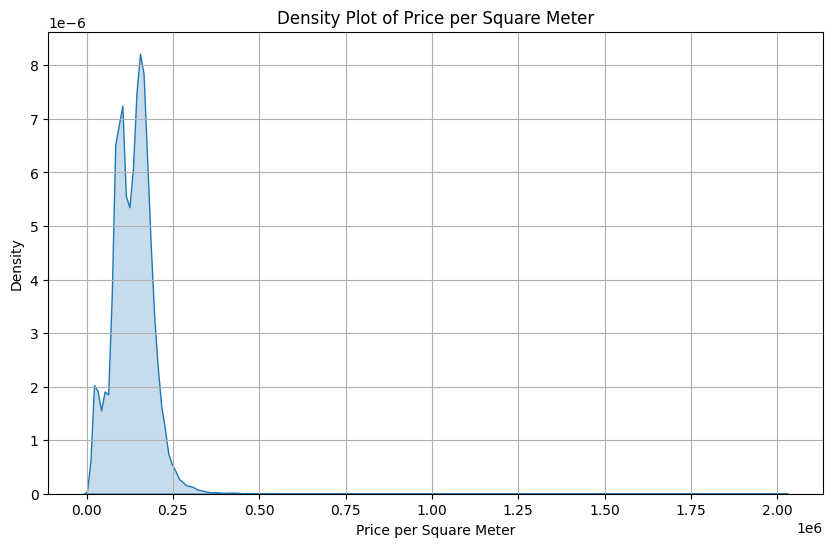

(29353, 292)

In [274]:
#calculate the price per sq meter
train_full['price_sq'] = train_full['price_doc'] / train_full['full_sq']
plt.figure(figsize=(10, 6))
sns.kdeplot(train_full["price_sq"], fill=True, bw_adjust=0.5)
plt.xlabel("Price per Square Meter")
plt.ylabel("Density")
plt.title("Density Plot of Price per Square Meter")
plt.grid(True)
plt.show()
# סינון לפי תנאים
train_full = train_full[
    (train_full['price_sq'] >= 29500) &
    (train_full['price_sq'] <= 470000)]
train_full = train_full.drop(columns=['price_sq'])
train_full.shape

In [270]:
# Load the data
df = train_full
# Keep only numeric columns
df = df.select_dtypes(include=["number"])
# Drop rows where `price_doc` is missing (y can't have NA values)
df = df.dropna(subset=["price_doc"])
# Split data into Train/Test sets
X = df.drop(columns=["price_doc"])
y = df["price_doc"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train an XGBoost model (handles NA values automatically)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)
# Predict prices
y_pred = model.predict(X_test)
# Calculate RMSLE
rmsle_value = rmsle(y_test, y_pred)
print(f"🔹 xgboost model RMSLE: {rmsle_value:.4f} ✅")

🔹 xgboost model RMSLE: 0.3343 ✅


In [ ]:
# PCA + category
columns_dict = {
    "general": ['price_doc', 'full_sq', 'life_sq', 'floor', 'max_floor', 'material', 'build_year', 'num_room', 'kitch_sq', 'state'],
    "population": [col for col in train_full.columns if any(sub in col for sub in ['full_all', 'male', 'female', 'young', 'work', 'ekder'])],
    "buildings": [col for col in train_full.columns if 'build_count' in col or 'raion_build_count' in col],
    "spatial": [col for col in train_full.columns if 'km' in col or 'min' in col],
    "quality": [col for col in train_full.columns if any(sub in col for sub in ['green', 'prom', 'gas', 'heating'])],
    "education_health": [col for col in train_full.columns if any(sub in col for sub in ['hospital', 'school', 'preschool', 'students'])],
    "leisure": [col for col in train_full.columns if any(sub in col for sub in ['theater', 'museum', 'sport', 'leisure'])],
    "transport_industry": [col for col in train_full.columns if any(sub in col for sub in ['railroad', 'office', 'shopping'])]}
def perform_pca_by_category(data, columns_dict, n_components=2):
    pca_results, pca_loadings = {}, {}
    for category, columns in columns_dict.items():
        numeric_columns = data[columns].select_dtypes(include=['number']).columns.intersection(data.columns)
        category_data = data[numeric_columns].dropna()
        if category_data.shape[1] < n_components:
            continue
        normalized_data = StandardScaler().fit_transform(category_data)
        pca = PCA(n_components=n_components).fit(normalized_data)
        pca_results[category] = pca.explained_variance_ratio_
        pca_loadings[category] = pd.DataFrame(pca.components_.T, index=numeric_columns, columns=[f"PC{i+1}" for i in range(n_components)])
    return pca_results, pca_loadings
pca_results, pca_loadings = perform_pca_by_category(train_full, columns_dict)
pca_results_df = pd.DataFrame.from_dict(pca_results, orient='index', columns=[f"PC{i+1}" for i in range(2)])
final_pca_data = pd.concat([train_full[columns_dict['general']]] + [train_full[list(set(loadings.abs().idxmax().tolist()))] for category, loadings in pca_loadings.items() if category != "general"], axis=1)
final_pca_data

In [ ]:
def create_pca_dataframe(data, pca_loadings, general_columns):
    # Create a new DataFrame
    pca_dataframes = []
    for category, loadings in pca_loadings.items():
        if category == "general":
            # Keep all original variables in the "general" category
            general_data = data[general_columns]
            pca_dataframes.append(general_data)
        else:
            # Select the most important variables from PC1 and PC2
            selected_columns = []
            for pc in loadings.columns:
                top_variables = loadings[pc].abs().sort_values(ascending=False).head(3)
                selected_columns += top_variables.index.tolist()
            selected_columns = list(set(selected_columns))
            pca_dataframes.append(data[selected_columns])
    # Combine all selected data into one DataFrame
    final_pca_data = pd.concat(pca_dataframes, axis=1)
    return final_pca_data
columns_general = columns_dict['general']
# Create a DataFrame with the selected PCA components
final_pca_data = create_pca_dataframe(train_full, pca_loadings, columns_general)
final_pca_data.info()

In [ ]:
'''# Create a new column: ratio between full_sq and life_sq
train_full['ratio_sq'] = train_full['full_sq'] / train_full['life_sq']
# List of columns to fill missing values
columns_to_fill = ['ratio_sq', 'max_floor', 'build_year', 'material', 'state']
# Group data by sub_area and metro_km_avto
grouped = train_full.groupby(['sub_area', 'metro_km_avto'])
# Function to fill missing values based on other observations in the same group
def fill_missing_values(group):
    group = group.copy()
    for column in columns_to_fill:
        if group[column].isnull().any():
            if group[column].isnull().all():
                continue
            # Fill numerical variables using mean
            if column == 'ratio_sq':
                mean_value = group[column].mean(skipna=True)  # Compute mean ignoring NaN
                if not np.isnan(mean_value):
                    group[column] = group[column].fillna(mean_value)
            elif column == 'max_floor':  # Special case for max_floor
                max_value = group[column].max(skipna=True)
                if not np.isnan(max_value):
                    group[column] = group[column].fillna(max_value) # Fill with max value
            elif group[column].dtype in ['float64', 'int64']:
                mean_value = group[column].mean(skipna=True)
                if not np.isnan(mean_value):
                    group[column] = group[column].fillna(round(mean_value))  # Round to nearest integer
            # Fill categorical variables using the most common value
            else:
                mode_value = group[column].mode()
                if not mode_value.empty:
                    group[column] = group[column].fillna(mode_value[0])
    return group
# Apply missing value imputation to each group
train_full = grouped.apply(fill_missing_values).reset_index(drop=True)
# Round values for relevant columns (except ratio_sq)
columns_to_round = [col for col in columns_to_fill if col != 'ratio_sq']
train_full[columns_to_round] = train_full[columns_to_round].apply(lambda x: x.fillna(x).round().astype('Int64'))'''

In [275]:
# Add useful features
# Calculate the average price per sub_area
avg_price_by_area = train_full.groupby('sub_area')['price_doc'].mean().reset_index()
avg_price_by_area.columns = ['sub_area', 'avg_price_sub_area']
avg_price_by_area = avg_price_by_area.sort_values(by='avg_price_sub_area', ascending=False)
# Create price categories: cheap, middle, expensive
avg_price_by_area['category'] = pd.qcut(
    avg_price_by_area['avg_price_sub_area'],
    q=3,
    labels=['cheap_area', 'middle_area', 'expensive_area'])
# Merge categories back into the test data
test_full = test_full.merge(avg_price_by_area[['sub_area', 'category']], on='sub_area', how='left')
# Create binary variables for each category
test_full['cheap_area'] = (test_full['category'] == 'cheap_area').astype(int)
test_full['middle_area'] = (test_full['category'] == 'middle_area').astype(int)
test_full['expensive_area'] = (test_full['category'] == 'expensive_area').astype(int)
test_full = test_full.drop(columns=['category'])

# Add useful numerical features
test_full['product'] = test_full['product_type'].apply(lambda x: 1 if x == 'Investment' else 0)
test_full['room_size'] = test_full['full_sq'] / test_full['num_room']
test_full['timestamp'] = pd.to_datetime(test_full['timestamp'])
test_full['bought_minus_built'] = test_full.timestamp.dt.year.astype(int) - test_full['build_year']
test_full['extra_area'] = test_full['full_sq'] - test_full['life_sq']
test_full['extra_area_ratio'] = test_full['extra_area']/test_full['full_sq']
# Handle missing values in num_room
imputer = SimpleImputer(strategy='most_frequent')
test_full['num_room'] = imputer.fit_transform(test_full[['num_room']])
# Repeat the same process for train data
avg_price_by_area = train_full.groupby('sub_area')['price_doc'].mean().reset_index()
avg_price_by_area.columns = ['sub_area', 'avg_price_sub_area']
avg_price_by_area = avg_price_by_area.sort_values(by='avg_price_sub_area', ascending=False)
# Create price categories for train data
avg_price_by_area['category'] = pd.qcut(
    avg_price_by_area['avg_price_sub_area'],
    q=3,
    labels=['cheap_area', 'middle_area', 'expensive_area'])
# Merge categories into train data
train_full = train_full.merge(avg_price_by_area[['sub_area', 'category']], on='sub_area', how='left')
# Create binary variables for price categories in train data
train_full['cheap_area'] = (train_full['category'] == 'cheap_area').astype(int)
train_full['middle_area'] = (train_full['category'] == 'middle_area').astype(int)
train_full['expensive_area'] = (train_full['category'] == 'expensive_area').astype(int)
train_full = train_full.drop(columns=['category'])
# Add numerical features to train data
train_full['product'] = train_full['product_type'].apply(lambda x: 1 if x == 'Investment' else 0)
train_full['room_size'] = train_full['full_sq'] / train_full['num_room']
train_full['timestamp'] = pd.to_datetime(train_full['timestamp'])
train_full['bought_minus_built'] = train_full.timestamp.dt.year.astype(int) - train_full['build_year']
train_full['extra_area'] = train_full['full_sq'] - train_full['life_sq']
train_full['extra_area_ratio'] = train_full['extra_area']/train_full['full_sq']
# Handle missing values in num_room for train data
imputer = SimpleImputer(strategy='most_frequent')
train_full['num_room'] = imputer.fit_transform(train_full[['num_room']])

In [276]:
# List of columns to keep
columns_to_keep = columns_to_keep = [
    "shopping_centers_km", "sport_count_5000", "school_education_centers_raion",
    "railroad_station_avto_km", "green_part_5000", "cafe_count_5000",
    "zd_vokzaly_avto_km", "sadovoe_km", "bought_minus_built", "ttk_km",
    "kremlin_km", "material", "workplaces_km", "ekder_all", "young_all",
    "product_type", "room_size", "kitch_size", "build_year", "cheap_area",
    "expensive_area", "floor", "kitch_sq", "state", "life_sq", "num_room",
    "full_sq", "price_doc", "id", "radiation_km", "basketball_km", "park_km",
    "museum_km", "cafe_sum_2000_min_price_avg", "cafe_sum_5000_min_price_avg",
    "prom_part_1500", "prom_part_2000", "green_part_1500", "green_part_3000",
    "public_transport_station_km", "public_transport_station_min_walk",
    "office_count_1500", "office_count_5000", "office_sqm_3000",
    "leisure_count_5000", "sport_count_2000", "sport_count_3000",
    "railroad_station_walk_km", "railroad_station_walk_min", "school_km",
    "preschool_quota","extra_area_ratio"
]
# Ensure all selected columns exist in train_full
columns_to_keep = [col for col in columns_to_keep if col in train_full.columns]
# Ensure all selected columns exist in test_full
columns_to_keep2 = [col for col in columns_to_keep if col in test_full.columns]
# Create new DataFrames with the selected columns
train_full = train_full[columns_to_keep]
test_full = test_full[columns_to_keep2]
# Check the shape of the filtered train dataset
train_full.shape

(29353, 51)

In [277]:
# Load the data
df = train_full
random.seed(42)
# Keep only numeric columns
df = df.select_dtypes(include=["number"])
# Drop rows where `price_doc` is missing (y can't have NA values)
df = df.dropna(subset=["price_doc"])
# Split data into Train/Test sets
X = df.drop(columns=["price_doc"])
y = df["price_doc"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Train an XGBoost model (handles NA values automatically)
model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=200, learning_rate=0.05, max_depth=4)
model.fit(X_train, y_train)
# Predict prices
y_pred = model.predict(X_test)
# Calculate RMSLE
rmsle_value = rmsle(y_test, y_pred)
print(f"🔹 xgboost model RMSLE: {rmsle_value:.4f} ✅")

🔹 xgboost model RMSLE: 0.3274 ✅


In [278]:
investment = train_full[train_full['product_type'] == 'Investment']
owner = train_full[train_full['product_type'] == 'OwnerOccupier']
investment_test = test_full[test_full['product_type'] == 'Investment']
owner_test = test_full[test_full['product_type'] == 'OwnerOccupier']
unknown_test = test_full[test_full['product_type'].isna()]
print(owner_test.shape)
print(investment_test.shape)
print(unknown_test.shape)

(2631, 50)
(4998, 50)
(33, 50)


In [279]:
# Function to calculate RMSLE
def rmsle(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, np.maximum(y_pred, 0)))  # למנוע בעיות עם ערכים שליליים
# Function to encode categorical variables
def preprocess_categorical(data):
    label_encoder = LabelEncoder()
    categorical_columns = data.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        data[col] = label_encoder.fit_transform(data[col].astype(str))
    return data

# Prepare data - remove NaN values from price_doc
train_full_clean = train_full.dropna(subset=["price_doc"])
investment_clean = investment.dropna(subset=["price_doc"])
owner_clean = owner.dropna(subset=["price_doc"])

# Convert categorical variables
train_full_clean = preprocess_categorical(train_full_clean)
investment_clean = preprocess_categorical(investment_clean)
owner_clean = preprocess_categorical(owner_clean)

# Split data into Train/Test for each dataset
X_full = train_full_clean.drop(columns=['price_doc'])
y_full = train_full_clean['price_doc']
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

X_inv = investment_clean.drop(columns=['price_doc'])
y_inv = investment_clean['price_doc']
X_train_inv, X_test_inv, y_train_inv, y_test_inv = train_test_split(X_inv, y_inv, test_size=0.2, random_state=42)

X_owner = owner_clean.drop(columns=['price_doc'])
y_owner = owner_clean['price_doc']
X_train_owner, X_test_owner, y_train_owner, y_test_owner = train_test_split(X_owner, y_owner, test_size=0.2, random_state=42)

# Create DMatrix for XGBoost
dtrain_full = xgb.DMatrix(X_train_full, label=y_train_full, enable_categorical=True)
dtest_full = xgb.DMatrix(X_test_full, label=y_test_full, enable_categorical=True)

dtrain_inv = xgb.DMatrix(X_train_inv, label=y_train_inv, enable_categorical=True)
dtest_inv = xgb.DMatrix(X_test_inv, label=y_test_inv, enable_categorical=True)

dtrain_owner = xgb.DMatrix(X_train_owner, label=y_train_owner, enable_categorical=True)
dtest_owner = xgb.DMatrix(X_test_owner, label=y_test_owner, enable_categorical=True)

# Set XGBoost parameters
params = {
    'n_estimators': 400,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 1,
    'reg_alpha': 0,
    'reg_lambda': 10,
    'seed': 42,
    'objective': 'reg:squarederror',
    'nthread': 8}

# Train XGBoost model on full dataset
model_full = xgb.train(
    params=params,
    dtrain=dtrain_full,
    num_boost_round=300,
    evals=[(dtest_full, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=False)

# Train XGBoost model on Investment dataset
model_inv = xgb.train(
    params=params,
    dtrain=dtrain_inv,
    num_boost_round=300,
    evals=[(dtest_inv, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=False)

# Train XGBoost model on Owner dataset
model_owner = xgb.train(
    params=params,
    dtrain=dtrain_owner,
    num_boost_round=300,
    evals=[(dtest_owner, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=False)

# Make predictions
y_pred_full = model_full.predict(dtest_full)
y_pred_inv = model_inv.predict(dtest_inv)
y_pred_owner = model_owner.predict(dtest_owner)

# Calculate RMSLE for each model
rmsle_full = rmsle(y_test_full, y_pred_full)
rmsle_inv = rmsle(y_test_inv, y_pred_inv)
rmsle_owner = rmsle(y_test_owner, y_pred_owner)

# Calculate combined RMSLE for Investment + Owner models
y_test_combined = np.concatenate([y_test_inv, y_test_owner])
y_pred_combined = np.concatenate([y_pred_inv, y_pred_owner])
rmsle_combined = rmsle(y_test_combined, y_pred_combined)

# Show results
results = pd.DataFrame({
    "Dataset": ["Full Dataset", "Investment", "Owner", "Combined"],
    "RMSLE": [rmsle_full, rmsle_inv, rmsle_owner, rmsle_combined]})
results

,Dataset,RMSLE
0,Full Dataset,0.322235
1,Investment,0.390872
2,Owner,0.112237
3,Combined,0.316751


In [280]:
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split

# Function to convert categorical variables to numbers, handling missing values
def preprocess_categorical(data, fitted_encoders=None):
    label_encoders = {} if fitted_encoders is None else fitted_encoders
    categorical_columns = data.select_dtypes(include=['object']).columns

    for col in categorical_columns:
        # Handle missing values in 'product_type' if needed
        if col == 'product_type':
            data[col] = data[col].fillna('Unknown')  # החלפת NaN ב־'Unknown'

        if col in label_encoders:
            unknown_mask = ~data[col].astype(str).isin(label_encoders[col].classes_)
            if unknown_mask.any():
                data.loc[unknown_mask, col] = 'Unknown'  # Assign unknown values to 'Unknown'
            data[col] = label_encoders[col].transform(data[col].astype(str))
        else:
            le = LabelEncoder()
            unique_values = data[col].astype(str).unique().tolist()
            if 'Unknown' not in unique_values:
                unique_values.append('Unknown')
            le.fit(unique_values)
            data[col] = le.transform(data[col].astype(str))
            label_encoders[col] = le

    return data, label_encoders

# Process categorical variables
train_full, label_encoders = preprocess_categorical(train_full)

# Prepare training data
X_train = train_full.drop(columns=['id', 'price_doc'])
y_train = train_full['price_doc']

# Split data into Train and Validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Create DMatrix for XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)

# XGBoost parameters
params = {
    'n_estimators': 400,
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.9,
    'colsample_bylevel': 1,
    'reg_alpha': 0,
    'reg_lambda': 10,
    'seed': 42,
    'objective': 'reg:squarederror',
    'nthread': 8
}

# Train the model
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=200,
    evals=[(dval, "Validation")],
    early_stopping_rounds=10,
    verbose_eval=False
)

# Function to make predictions
def predict_prices(test_data, model, label_encoders, train_columns):
    test_data, _ = preprocess_categorical(test_data, label_encoders)

    ids = test_data['id']
    test_data = test_data[train_columns]
    # Create DMatrix and make predictions
    dtest = xgb.DMatrix(test_data, enable_categorical=True)
    predictions = model.predict(dtest) * 0.96
    # Return DataFrame with IDs and predicted prices
    result = pd.DataFrame({"id": ids, "price_doc": predictions})

    return result

# Make predictions for each dataset
investment_predictions = predict_prices(investment_test, model, label_encoders, train_full.columns.drop(['id', 'price_doc']))
owner_predictions = predict_prices(owner_test, model, label_encoders, train_full.columns.drop(['id', 'price_doc']))
unknown_predictions = predict_prices(unknown_test, model, label_encoders, train_full.columns.drop(['id', 'price_doc']))

# Combine all predictions
combined_predictions = pd.concat([investment_predictions, owner_predictions, unknown_predictions])
# Save predictions to files
combined_predictions.to_excel("combined_predictions.xlsx", index=False)
combined_predictions.to_csv("combined_predictions.csv",index=False)